In [1]:
from googleapiclient.discovery import build
import pandas as pd

# API credentials
api_key = '#'
video_id = "4rX4sH8PMFc"

# YouTube API setup
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = api_key

try:
    youtube = build(api_service_name, api_version, developerKey=DEVELOPER_KEY)
    comments_in_video = []  # Liste pour stocker tous les commentaires

    # Commencer à récupérer les commentaires
    request = youtube.commentThreads().list(
        part="snippet,replies",
        videoId=video_id,
        maxResults=100  # Maximum autorisé par requête
    )
    while request:
        response = request.execute()

        # Extraire les commentaires de la réponse actuelle
        for item in response.get("items", []):
            top_comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
            comments_in_video.append(top_comment)

            # Si des réponses sont incluses, vous pouvez également les extraire
            if 'replies' in item:
                for reply in item['replies']['comments']:
                    comments_in_video.append(reply['snippet']['textOriginal'])

        # Vérifier s'il y a une autre page
        request = youtube.commentThreads().list_next(request, response)

   # Enregistrer les commentaires dans un DataFrame
    comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
    comments = pd.DataFrame(comments_in_video_info)

    # Enregistrer dans un fichier
    fname = f"comments_{video_id}.csv"
    comments.to_csv(fname, index=False, encoding="utf-8")
    print(f"Comments saved to {fname}")
except Exception as e:
    print(f"Could not get comments for video {video_id}: {e}")


Comments saved to comments_4rX4sH8PMFc.csv


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import nltk

# Télécharger les ressources VADER
nltk.download('vader_lexicon')

# Charger les commentaires
file_name = "comments_4rX4sH8PMFc.csv"
df = pd.read_csv(file_name)

# Initialiser l'analyseur
sia = SentimentIntensityAnalyzer()

# Analyse des sentiments
def get_sentiment_vader(comment):
    score = sia.polarity_scores(comment)
    if score['compound'] > 0.005:
        return "Positive"
    elif score['compound'] < -0.005:
        return "Negative"
    else:
        return "Neutral"

# Appliquer l'analyse des sentiments
df['Sentiment'] = df['comments'].apply(get_sentiment_vader)

# Résumé
sentiments=df['Sentiment'].value_counts()
print(sentiments)

# Sauvegarder le résultat
df.to_csv("comments_with_sentiments.csv", index=False, encoding="utf-8")
print("Résultats enregistrés dans 'comments_with_sentiments.csv'")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment
Positive    415
Neutral     191
Negative     32
Name: count, dtype: int64
Résultats enregistrés dans 'comments_with_sentiments.csv'


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Charger les commentaires
file_name = "comments_4rX4sH8PMFc.csv"
df = pd.read_csv(file_name)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['comments'])

# Clustering K-Means
num_clusters = 5  # Ajustez selon vos besoins
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Ajouter les clusters aux données
df['Cluster'] = kmeans.labels_

# Afficher les commentaires par cluster
L=[]
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    print(df[df['Cluster'] == cluster]['comments'].head(10))
    L.append(df[df['Cluster'] == cluster]['comments'].head(10))
    print("\n")

# Sauvegarder le résultat
df.to_csv("comments_with_clusters.csv", index=False, encoding="utf-8")
print("Résultats enregistrés dans 'comments_with_clusters.csv'")


Cluster 0:
110    I just love Anne with an E, wish there was sea...
114                                Season 4 please... 🥹🥹
115    I both watched the series and read the books m...
117              SEASON 4 IS WHAT WE NEED TO LIVEEEEEEEE
133        We need season 4 for sure.It's way too good!!
180      no there is 3 season in turkey  i am not crying
238          FOURTH SEASON OF ANNE WITH AN E RIGHT NOWWW
259    I'm looking forward to the FOURTH SEASON OF An...
290    Fourth season plz😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😒🙏🏻🙏🏻🙏🏻🙏🏻...
337                  I would learn if there is season 4.
Name: comments, dtype: object


Cluster 1:
14                                             Thank you
45         I love the way you teach! Thank you very much
62                    Thank you for watching the lesson!
75                           Thank you for your support!
100                       Thank your for this lesson! <3
105    Wonderful English review 😅😊thank you for your ...
106                               

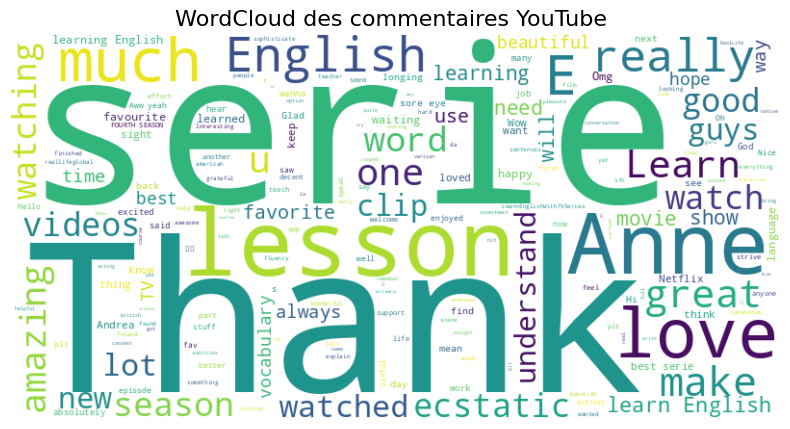

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Charger les commentaires
file_name = "comments_4rX4sH8PMFc.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_name)

# Combiner tous les commentaires en une seule chaîne de texte
all_comments = " ".join(comment for comment in df['comments'])

# Définir les mots à exclure
custom_stopwords = set(STOPWORDS)  # Inclut déjà des mots comme "the", "and", etc.
custom_stopwords.update(["like", "video", "comment", "channel", "https", "subscribe","youtube","please","Hey"])  # Ajoutez les mots spécifiques

# Générer le WordCloud avec les mots exclus
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=custom_stopwords
).generate(all_comments)

# Afficher le WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des commentaires YouTube ", fontsize=16)
plt.show()


In [5]:
gemini_api = "#"
key= "#"

In [6]:
!pip install google-cloud


In [ ]:
!pip install -q -U google-generativeai

In [7]:
from re import A
import google.generativeai as genai

genai.configure(api_key=gemini_api)
model = genai.GenerativeModel("gemini-1.5-flash")
prompt = f"""
    Voici les résultats d'analyse des commentaires d'utilisateurs sur une vidéo YouTube :
    {wordcloud,A,L}

    Analysez ces commentaires pour identifier les 3 principales attentes ou préoccupations des utilisateurs.
    Rédigez un commentaire clair et concis qui résume ces attentes et propose des solutions adaptées.
    """
response = model.generate_content(prompt)
print(response.text)

L'analyse des commentaires révèle trois préoccupations principales des utilisateurs :

1. **Demande pressante pour une saison 4 d'Anne with an E :**  De nombreux commentaires expriment un désir intense pour une nouvelle saison de la série.  C'est le thème le plus dominant.

2. **Besoin de suites et de contenus supplémentaires :**  Plusieurs commentaires demandent une deuxième partie des leçons d'Anne, suggérant un besoin de contenu complémentaire ou de prolongements des leçons existantes.

3. **Remerciements et satisfaction générale :** Bien que moins une préoccupation qu'une observation, de nombreux commentaires expriment leur gratitude pour le contenu proposé, soulignant la qualité des leçons et la satisfaction générale.  Cela indique que le contenu est apprécié et qu'il faut le maintenir.


**Commentaire récapitulatif et propositions de solutions:**

"Merci pour tous vos commentaires ! Nous avons bien noté votre enthousiasme pour *Anne with an E* et votre demande pour une saison 4. 

In [8]:
! pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 24.8 MB/s eta 0:00:00


In [9]:
import yt_dlp

# Récupérer l'audio d'une vidéo YouTube
def download_audio(url):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'outtmpl': '%(title)s.%(ext)s',
        'verbose': True,
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

URL = "https://www.youtube.com/watch?v=tbnzAVRZ9Xc"
download_audio(URL)

# Récupérer le nom du fichier audio
video_title = yt_dlp.YoutubeDL({}).extract_info(URL, download=False)['title']
audio_file = f'{video_title}.mp3'

[debug] Encodings: locale UTF-8, fs utf-8, pref UTF-8, out UTF-8 (No ANSI), error UTF-8 (No ANSI), screen UTF-8 (No ANSI)
[debug] yt-dlp version stable@2024.12.23 from yt-dlp/yt-dlp [65cf46cdd] (pip) API
[debug] params: {'format': 'bestaudio/best', 'postprocessors': [{'key': 'FFmpegExtractAudio', 'preferredcodec': 'mp3', 'preferredquality': '192'}], 'outtmpl': '%(title)s.%(ext)s', 'verbose': True, 'compat_opts': set(), 'http_headers': {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8', 'Accept-Language': 'en-us,en;q=0.5', 'Sec-Fetch-Mode': 'navigate'}}
[debug] Python 3.10.12 (CPython x86_64 64bit) - Linux-6.1.85+-x86_64-with-glibc2.35 (OpenSSL 3.0.2 15 Mar 2022, glibc 2.35)
[debug] exe versions: ffmpeg 4.4.2 (setts), ffprobe 4.4.2
[debug] Optional libraries: certifi-2024.12.14, requests-2.32.3, secretstorage-3.3.1, sqlite3-3.37.2,

[youtube] Extracting URL: https://www.youtube.com/watch?v=tbnzAVRZ9Xc
[youtube] tbnzAVRZ9Xc: Downloading webpage
[youtube] tbnzAVRZ9Xc: Downloading ios player API JSON
[youtube] tbnzAVRZ9Xc: Downloading mweb player API JSON


[debug] [youtube] tbnzAVRZ9Xc: ios client https formats require a PO Token which was not provided. They will be skipped as they may yield HTTP Error 403. You can manually pass a PO Token for this client with --extractor-args "youtube:po_token=ios+XXX. For more information, refer to  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#po-token-guide . To enable these broken formats anyway, pass --extractor-args "youtube:formats=missing_pot"


[youtube] tbnzAVRZ9Xc: Downloading player 3ede36f2


[debug] Saving youtube-nsig.3ede36f2 to cache
[debug] [youtube] Decrypted nsig WPQhNwrfSNr_FiYD3k => PgWVnkQtM2f1ig
[debug] Loading youtube-nsig.3ede36f2 from cache
[debug] [youtube] Decrypted nsig -DAtAnKxEupYi8oH0b => gHF2t2Hw3CRnTQ


[youtube] tbnzAVRZ9Xc: Downloading m3u8 information


[debug] Sort order given by extractor: quality, res, fps, hdr:12, source, vcodec, channels, acodec, lang, proto
[debug] Formats sorted by: hasvid, ie_pref, quality, res, fps, hdr:12(7), source, vcodec, channels, acodec, lang, proto, size, br, asr, vext, aext, hasaud, id


[info] tbnzAVRZ9Xc: Downloading 1 format(s): 251


[debug] Invoking http downloader on "https://rr2---sn-5ualdnls.googlevideo.com/videoplayback?expire=1736660984&ei=mAODZ6-JEuSLkucP-OSv2AM&ip=34.73.224.229&id=o-AOrOSg47h7TT25YpHmGgNuZQc8DAeniuD9j-pdEdVvZe&itag=251&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1736639384%2C&mh=kQ&mm=31%2C29&mn=sn-5ualdnls%2Csn-5uaeznlz&ms=au%2Crdu&mv=u&mvi=2&pl=20&rms=au%2Cau&bui=AY2Et-M0GjHnQR-FA2u8BAeBmPDt1U6_poBLx1CRecEuUKGIuC5SsqO5TtnN9o-4m8wzyio--igzyy72&vprv=1&svpuc=1&mime=audio%2Fwebm&ns=ef0Sm5TtJXzb1Cco5QmniEIQ&rqh=1&gir=yes&clen=10491966&dur=605.161&lmt=1709339654353249&mt=1736638776&fvip=3&keepalive=yes&fexp=51326932%2C51331020%2C51335594%2C51353498%2C51371294&c=MWEB&sefc=1&txp=4532434&n=gHF2t2Hw3CRnTQ&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Cgir%2Cclen%2Cdur%2Clmt&sig=AJfQdSswRQIgO0v0plWAY2FDYEQSph9BgpdPxYhFWJAXStiedsm0plwCIQDoEyzjtXfbGO4LjjNOVGYCJ4qjBmaU_hpeXY0I6wti1g%3D%3D&lsparams=met%2Cmh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2

[download] Destination: WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.webm
[download] 100% of   10.01MiB in 00:00:00 at 18.26MiB/s  


[debug] ffmpeg command line: ffprobe -show_streams 'file:WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.webm'


[ExtractAudio] Destination: WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.mp3


[debug] ffmpeg command line: ffmpeg -y -loglevel repeat+info -i 'file:WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.webm' -vn -acodec libmp3lame -b:a 192.0k -movflags +faststart 'file:WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.mp3'


Deleting original file WATCH THIS EVERYDAY AND CHANGE YOUR LIFE - Denzel Washington Motivational Speech.webm (pass -k to keep)
[youtube] Extracting URL: https://www.youtube.com/watch?v=tbnzAVRZ9Xc
[youtube] tbnzAVRZ9Xc: Downloading webpage
[youtube] tbnzAVRZ9Xc: Downloading ios player API JSON
[youtube] tbnzAVRZ9Xc: Downloading mweb player API JSON
[youtube] tbnzAVRZ9Xc: Downloading m3u8 information


In [10]:
! apt-get install ffmpeg
! pip install yt-dlp assemblyai

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00


In [11]:
import assemblyai as aai

aai.settings.api_key = "#"
transcriber = aai.Transcriber()



In [14]:

# Generate transcript
transcriber = aai.Transcriber()
transcript = transcriber.transcribe(audio_file)

# Créer des paragraphes et leur attribuer des horodatages
paragraphs = transcript.get_paragraphs()
combined_paragraphs = []
step = 2

for i in range(0, len(paragraphs), step):
    paragraph_group = paragraphs[i : i + step]
    start = paragraph_group[0].start
    end = paragraph_group[-1].end
    text = ""
    for paragraph in paragraph_group:
        text += f"{paragraph.text} "
    combined_paragraphs.append(f"Paragraph: {text} Start: {start} End: {end}")


In [15]:
combined_paragraphs

["Paragraph: I found that nothing in life is worthwhile unless you take risks. Nothing. Nelson Mandela said, there is no passion to be found playing small and settling for a life that's less than the one you're capable of living now. I'm sure in your experiences in school and applying to college and picking your major and deciding what you want to do with life, I'm sure people have told you to make sure you have something to fall back on. Make sure you got something to fall back on, honey. But I never understood that concept, having something to fall back on. If I'm going to fall, I don't want to fall back on anything. I want to fall forward. I figure at least this way I'll see what I'm going to hit. Without consistency, you'll never finish.  Start: 7600 End: 62570",
 "Paragraph: So do what you feel passionate about. Passionate about. Take chances. Don't be afraid to fail. There's an old IQ test was nine dots, and you had to draw five lines with a pencil within these nine dots without 

In [16]:
import assemblyai as aai

# Configuration de la clé API
aai.settings.api_key = "#"

# Pour chaque paragraphe
results = []
# Itérer sur la liste combined_paragraphs
for paragraph_info in combined_paragraphs:
    # Extraire le texte et les horodatages à partir des informations du paragraphe
    parts = paragraph_info.split(" Start: ")
    text = parts[0].replace("Paragraph: ", "")
    timestamps = parts[1].split(" End: ")
    start_time = int(timestamps[0])

    # Convertir les millisecondes au format MM:SS
    minutes = start_time // 1000 // 60
    seconds = (start_time // 1000) % 60
    timestamp = f"{minutes}:{seconds:02d}"

    # Ajouter le texte formaté avec son horodatage
    results.append(f"{timestamp} {text}")

# Afficher les résultats
for result in results:
    print(f"{result}\n")

0:07 I found that nothing in life is worthwhile unless you take risks. Nothing. Nelson Mandela said, there is no passion to be found playing small and settling for a life that's less than the one you're capable of living now. I'm sure in your experiences in school and applying to college and picking your major and deciding what you want to do with life, I'm sure people have told you to make sure you have something to fall back on. Make sure you got something to fall back on, honey. But I never understood that concept, having something to fall back on. If I'm going to fall, I don't want to fall back on anything. I want to fall forward. I figure at least this way I'll see what I'm going to hit. Without consistency, you'll never finish. 

1:04 So do what you feel passionate about. Passionate about. Take chances. Don't be afraid to fail. There's an old IQ test was nine dots, and you had to draw five lines with a pencil within these nine dots without lifting the pencil. The only way to do i

In [17]:
import google.generativeai as genai

genai.configure(api_key=gemini_api)
model = genai.GenerativeModel("gemini-1.5-flash")
prompt = "What are the 5 key messages that Steve Jobs wanted to convey in the speech? Please explain in Spanish."

response = model.generate_content(prompt)
print(response.text)

Steve Jobs dio muchos discursos memorables, pero si nos referimos a uno en particular, necesitaría saber a qué discurso te refieres (por ejemplo, el de la graduación de Stanford).  Asumiendo que te refieres al discurso de Stanford de 2005,  podríamos identificar 5 mensajes clave que Jobs quiso transmitir:

1. **Conectar los puntos:** Jobs enfatizó la importancia de aceptar las experiencias aparentemente negativas o aleatorias de la vida, ya que con el tiempo, estas se conectan y dan sentido a nuestro camino.  No se puede prever el futuro, pero se debe confiar en que las cosas encajarán.  *Mensaje en español:*  La vida te presentará experiencias aparentemente inconexas.  Acepta las curvas del camino, pues más tarde entenderás cómo te han llevado a donde estás.

2. **Amar lo que haces:** Jobs insistió en la necesidad de encontrar una pasión y dedicarse a ella con fervor.  El trabajo debe ser algo que te apasione, para poder superar los obstáculos y disfrutar del proceso. *Mensaje en espa

In [18]:
import google.generativeai as genai
import assemblyai as aai

# Configuration de la clé API AssemblyAI
aai.settings.api_key = "#"

# Configuration de la clé API Gemini
genai.configure(api_key=gemini_api)
model = genai.GenerativeModel("gemini-1.5-flash")

# Transcription de l'audio
transcriber = aai.Transcriber()
transcript = transcriber.transcribe(audio_file)

# Utilisation de la transcription comme prompt
prompt = "What are the 4 key messages that Steve Jobs wanted to convey in the speech? Please explain in fench."


# Génération de la réponse
response = model.generate_content(prompt)
print(response.text)

Dans son discours de Stanford en 2005, Steve Jobs cherchait à transmettre plusieurs messages clés, mais on peut en identifier quatre principaux :

1. **L'importance de suivre sa propre voie (Connecter les points):**  Jobs insiste sur le fait que les choix qui semblent aléatoires ou des échecs au moment où ils surviennent peuvent finalement s'avérer cruciaux dans la construction de son avenir. Il encourage l'audience à avoir confiance en l'avenir et à croire que les expériences, même négatives, finissent par se connecter et former un tout cohérent.  L'idée est de ne pas avoir peur de prendre des risques et de suivre son intuition, même si cela semble déraisonnable à court terme.  *« Vous ne pouvez pas connecter les points en regardant vers l'avant; vous ne pouvez les connecter qu'en regardant vers l'arrière.  Vous devez donc faire confiance que les points se connecteront dans votre avenir. »*

2. **L'acceptation de l'échec et la persévérance (La mort):**  Jobs aborde la mort de manière 